In [ ]:
!pip3 install transformers

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from scipy import spatial
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
from transformers import (
    BertModel, BertConfig, BertTokenizer, TrainingArguments, 
    Trainer, LineByLineTextDataset, DataCollatorForLanguageModeling,
    DataCollatorWithPadding, DataCollator, BertForMaskedLM, BertForPreTraining
)

# Достаём эмбеддинги из предобученного BERT

## Загружаем модель

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased', output_hidden_states=True)
model = BertModel.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer = BertTokenizer.from_pretrained('google/bert_uncased_L-12_H-128_A-2')
config = BertConfig.from_pretrained('google/bert_uncased_L-12_H-128_A-2', output_hidden_states=True)
model = BertModel.from_pretrained('google/bert_uncased_L-12_H-128_A-2', config=config)

Some weights of the model checkpoint at google/bert_uncased_L-12_H-128_A-2 were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Функции для эмбеддингов

In [ ]:
text = 'perfect weather'
def get_ids_tokens(text, tokenizer=tokenizer):
    tokens = tokenizer.tokenize('[CLS] ' + text + ' [SEP]')
    ids = tokenizer.encode(text)
    return ids, tokens

get_ids_tokens(text)

([101, 3819, 4633, 102], ['[CLS]', 'perfect', 'weather', '[SEP]'])

In [ ]:
def get_embeddings_from_last(text, tokenizer=tokenizer, model=model):
    """Вытягивает векторные представления для слов в тексте как крайние hidden states"""
    encoded_input = tokenizer(text, return_tensors='pt')
    word_embeddings = model(**encoded_input)[2][-1][0].detach().numpy()[1:-1]
    return word_embeddings

get_embeddings_from_last('hello there guys').shape

(3, 128)

In [ ]:
k, q, m, w = get_embeddings_from_last("king queen man woman")
spatial.distance.cosine(k - m + w, q)

0.1589096188545227

In [ ]:
def get_embeddings(text, tokenizer=tokenizer, model=model):
    """Вытягивает векторные представления для слов в тексте на основе 4 крайних hidden states"""
    encoded_input = tokenizer(text, return_tensors='pt')
    four_last_hidden = model(**encoded_input)[2][-4:]
    four_last_hidden = np.asarray([hidden[0].detach().numpy() for hidden in four_last_hidden])
    word_embeddings = four_last_hidden[:, 1:-1].sum(axis=0)
    return word_embeddings

# get_embeddings("king queen man woman")

In [ ]:
|k, q, m, w = get_embeddings("king queen man woman")
spatial.distance.cosine(k - m + w, q)

SyntaxError: ignored

Как предлагается в статье, в качестве эмбеддинга будем брать четыре hidden state'а вместо одного последнего.

## Сохраняем эмбеддинги для всех слов в словаре

In [ ]:
all_embeddings = []  # list of all embeddings in vocabulary

for word in tqdm(tokenizer.ids_to_tokens.values()):
    all_embeddings.append(get_embeddings(word)[0])

In [ ]:
# np.save('bert-base-uncased-embeddings.npy', np.asarray(all_embeddings))
# np.save('drive/MyDrive/Coursework2021/bert_base_uncased_vocab_embeddings.npy', np.asarray(all_embeddings))

np.save('bert-base-uncased-embeddings.npy', np.asarray(all_embeddings))
np.save('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab_embeddings.npy', np.asarray(all_embeddings))

In [ ]:
# # with open('bert_base_uncased_tokens.txt', 'w') as f:
# #     for token in tokenizer.ids_to_tokens.values():
# #         print(token, file=f)
# # with open('drive/MyDrive/Coursework2021/bert_base_uncased_vocab.txt', 'w') as f:
# #     for token in tokenizer.ids_to_tokens.values():
# #         print(token, file=f)

# with open('bert_base_uncased_tokens.txt', 'w') as f:
#     for token in tokenizer.ids_to_tokens.values():
#         print(token, file=f)
# with open('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab.txt', 'w') as f:
#     for token in tokenizer.ids_to_tokens.values():
#         print(token, file=f)

In [ ]:
embeddings = np.load('bert-base-uncased-embeddings.npy')
assert (all_embeddings == embeddings).mean() == 1

FileNotFoundError: ignored

# Строим автоенкодер

TODO: сэмплировать обучающую выборку по частотности.

In [ ]:
all_embeddings = np.load('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab_embeddings.npy')
with open('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab.txt', 'r') as f:
    all_tokens = f.read().split('\n')[:-1]

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.layers import InputLayer, Dense
from keras.models import Model, Sequential

ORIGINAL_DIM = 128
TARGET_DIM = 64

encoder = Sequential([
    InputLayer(input_shape=(ORIGINAL_DIM,)),
    Dense(90, activation='LeakyReLU'),
    # Dense(32, activation='relu'),
    Dense(TARGET_DIM, activation='LeakyReLU')
])

decoder = Sequential([
    InputLayer(input_shape=(TARGET_DIM,)),
    # Dense(32, activation='relu'),
    Dense(90, activation='LeakyReLU'),
    Dense(ORIGINAL_DIM, activation=None)
])

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
autoencoder.count_params()

34932

In [ ]:
model_history = autoencoder.fit(all_embeddings, all_embeddings, epochs=50, batch_size=32, verbose=True, validation_split=0.1, shuffle=True)
# model_history = autoencoder.fit(get_embeddings('king queen man woman'), get_embeddings('king queen man woman'), epochs=1000, batch_size=32, verbose=False)

Epoch 1/50
859/859 [==============================] - 2s 2ms/step - loss: 3.5574 - val_loss: 0.6818
Epoch 2/50
859/859 [==============================] - 2s 2ms/step - loss: 0.6002 - val_loss: 0.4728
Epoch 3/50
859/859 [==============================] - 1s 2ms/step - loss: 0.3816 - val_loss: 0.3722
Epoch 4/50
859/859 [==============================] - 1s 2ms/step - loss: 0.3014 - val_loss: 0.3498
Epoch 5/50
859/859 [==============================] - 2s 2ms/step - loss: 0.2532 - val_loss: 0.2999
Epoch 6/50
859/859 [==============================] - 2s 2ms/step - loss: 0.2270 - val_loss: 0.2782
Epoch 7/50
859/859 [==============================] - 2s 2ms/step - loss: 0.2039 - val_loss: 0.2366
Epoch 8/50
859/859 [==============================] - 2s 2ms/step - loss: 0.1929 - val_loss: 0.2072
Epoch 9/50
859/859 [==============================] - 1s 2ms/step - loss: 0.1781 - val_loss: 0.1949
Epoch 10/50
859/859 [==============================] - 2s 2ms/step - loss: 0.1702 - val_loss: 0.1818

KeyboardInterrupt: ignored

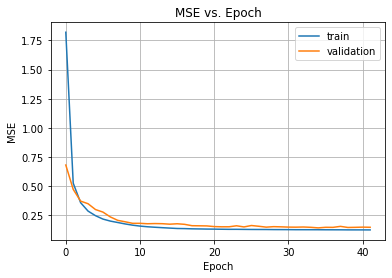

In [ ]:
plt.plot(autoencoder.history.history["loss"], label='train')
plt.plot(autoencoder.history.history["val_loss"], label='validation')
plt.title("MSE vs. Epoch")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score

mape(all_embeddings, autoencoder(all_embeddings)), mae(all_embeddings, autoencoder(all_embeddings)), r2_score(all_embeddings, autoencoder(all_embeddings))

(0.83619845, 0.26635018, 0.9726335104011173)

In [ ]:
def mape1(a, b): 
    mask = a != 0
    return np.fabs((a - b)/a)[mask].mean()
mape1(all_embeddings, autoencoder(all_embeddings))

0.8361991

In [ ]:
len(all_tokens), all_embeddings.shape

(30523, (30522, 128))

## Сэмплирую

In [ ]:
# sentences = []
# with open('drive/MyDrive/Coursework2021/english_corpus_sentences.txt', 'r') as f:
#     for line in f:
#         if len(sentences) == 1000:
#             break
#         sentences.append(line)

with open('drive/MyDrive/Coursework2021/sticked_file.txt', 'r') as f:
    text = f.read()

print(text[:500])
print(' '.join(tokenizer.tokenize(text[:500])))

chapter HE HE have just strike NUMBER from the cuckoo clock that hang over the mantelpiece in the dining room when victorine bring in the halve watermelon and set HE in front of mr
bessemer be plate
then HE go down to the front door for the damp twisted roll of the DATE TIME be paper and come back and ring the breakfast bell for the FIRST time
as the family still hesitate to appear HE go to the bay window at the end of the room and stand there for a moment look out
the view be wonderful
the bess
chapter he he have just strike number from the cuckoo clock that hang over the man ##tel ##piece in the dining room when victor ##ine bring in the hal ##ve water ##mel ##on and set he in front of mr be ##sse ##mer be plate then he go down to the front door for the damp twisted roll of the date time be paper and come back and ring the breakfast bell for the first time as the family still hesitate to appear he go to the bay window at the end of the room and stand there for a moment look out the v

In [ ]:
tokenized = tokenizer.tokenize(text)

In [ ]:
from collections import Counter
token2freq = Counter(tokenized)

In [ ]:
total_tokens = sum(list(token2freq.values()))
total_tokens

2060298

In [ ]:
weights = np.array([token2freq[token] / total_tokens for token in all_tokens])
sorted(weights)[::-1][:20]

[0.11771889309216434,
 0.052290979266106166,
 0.04046453474206158,
 0.02978112874933626,
 0.026824274934985133,
 0.023588820646333684,
 0.02170414182802682,
 0.015475916590706781,
 0.014179016821838395,
 0.012284145303252248,
 0.009526291827687062,
 0.007728008278414094,
 0.007330007600842208,
 0.007056260793341546,
 0.006322871739913353,
 0.0058967197949034555,
 0.005592394886564953,
 0.005571524119326428,
 0.004973552369608668,
 0.004965786502729217]

In [ ]:
weights.shape, all_embeddings.shape

((30522,), (30522, 128))

In [ ]:
sorted(weights * all_embeddings.shape[0])[::-1][10000]

0.07407180902956756

In [ ]:
model_history = autoencoder.fit(all_embeddings, all_embeddings, epochs=50, batch_size=32, verbose=True, validation_split=0.1, sample_weight=weights * all_embeddings.shape[0])

KeyboardInterrupt: ignored

In [ ]:
sorted_tokens = list(sorted(all_tokens, key=lambda x: token2freq[x] or 0))[::-1]
sorted_tokens[:5]

['he', 'the', 'be', 'and', 'of']

In [ ]:
token2embedding = dict(zip(all_tokens, all_embeddings))
mse(autoencoder(token2embedding['he'].reshape(1, 128)).numpy()[0], token2embedding['he'])

9.290254

In [ ]:
sorted_embeddings = np.asarray([token2embedding[token] for token in sorted_tokens])
sorted_embeddings.shape

(30522, 128)

In [ ]:
weights.sum()

1.0

In [ ]:
np.sum(weights * np.mean((sorted_embeddings - autoencoder(sorted_embeddings)) ** 2, axis=1))

2.3368134092241215

In [ ]:
from sklearn.metrics import mean_squared_error as mse
mse(all_embeddings, autoencoder(all_embeddings)), mape(all_embeddings, autoencoder(all_embeddings)), mae(all_embeddings, autoencoder(all_embeddings)), r2_score(all_embeddings, autoencoder(all_embeddings))

(2.8428922, 3.7630105, 1.2740923, 0.40276765456620534)

## По-другому

In [ ]:
dataset = []
sorted_scores = list(sorted(weights * total_tokens)[::-1])
sorted_scores = np.array([max(1, int(score / 20)) for score in sorted_scores])
np.sum(sorted_scores)

121944

In [ ]:
sampled_embeddings = []
for emb, score in zip(sorted_embeddings, sorted_scores):
    sampled_embeddings += [emb] * score
sampled_embeddings = np.asarray(sampled_embeddings)
sampled_embeddings.shape

(121944, 128)

In [ ]:
from sklearn.model_selection import train_test_split

train_sampled_embeds, val_sampled_embeds = train_test_split(sampled_embeddings, train_size=0.8, random_state=12)
train_sampled_embeds.shape, val_sampled_embeds.shape

((97555, 128), (24389, 128))

In [ ]:
autoencoder.fit(train_sampled_embeds, train_sampled_embeds, verbose=True, validation_data=(val_sampled_embeds, val_sampled_embeds), epochs=50, shuffle=True, batch_size=32, validation_batch_size=32)

Epoch 1/50
3049/3049 [==============================] - 6s 2ms/step - loss: 1.9463 - val_loss: 0.2656
Epoch 2/50
3049/3049 [==============================] - 5s 2ms/step - loss: 0.2301 - val_loss: 0.1718
Epoch 3/50
3049/3049 [==============================] - 6s 2ms/step - loss: 0.1628 - val_loss: 0.1459
Epoch 4/50
3049/3049 [==============================] - 5s 2ms/step - loss: 0.1394 - val_loss: 0.1287
Epoch 5/50
3049/3049 [==============================] - 6s 2ms/step - loss: 0.1280 - val_loss: 0.1223
Epoch 6/50
3049/3049 [==============================] - 6s 2ms/step - loss: 0.1224 - val_loss: 0.1173
Epoch 7/50
3049/3049 [==============================] - 6s 2ms/step - loss: 0.1179 - val_loss: 0.1187
Epoch 8/50
3049/3049 [==============================] - 5s 2ms/step - loss: 0.1157 - val_loss: 0.1136
Epoch 9/50
3049/3049 [==============================] - 6s 2ms/step - loss: 0.1126 - val_loss: 0.1187
Epoch 10/50
3049/3049 [==============================] - 6s 2ms/step - loss: 0.110

In [ ]:
text_embeddings = []
for token in tokenized[:400_000]:
    text_embeddings.append(token2embedding[token])

text_embeddings = np.asarray(text_embeddings)

embs = autoencoder(text_embeddings)
print(mse(text_embeddings, embs))
print(mape(text_embeddings, embs))
print(r2_score(text_embeddings, embs))

0.07778654
0.54310894
0.9825532438257183


In [ ]:
def init_autoencoder(dims, activation):
    encoder = Sequential([
        InputLayer(input_shape=(dims[0],)),
    ])
    for dim in dims[1:]:
        encoder.add(Dense(dim, activation=activation))
    
    decoder = Sequential([
        InputLayer(input_shape=(dims[-1],)),   
    ])
    for dim in dims[-2:0:-1]:
        decoder.add(Dense(dim, activation=activation))
    decoder.add(Dense(dims[0], activation=None))
    
    autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
    autoencoder.compile(loss='mse', optimizer='adam')
    return autoencoder

In [ ]:
activations = ['LeakyReLU', 'relu', 'tanh', 'sigmoid', None]
autoencoders = []

for activation in tqdm(activations):
    autoencoder = init_autoencoder([128, 90, 64], activation)
    autoencoder.fit(train_sampled_embeds, train_sampled_embeds, verbose=False, validation_data=(val_sampled_embeds, val_sampled_embeds), epochs=50, shuffle=True, batch_size=32, validation_batch_size=32)
    autoencoders.append(autoencoder)

0.08973991125822067
0.23930180072784424
0.1717672049999237
0.12061691284179688
0.1394190937280655


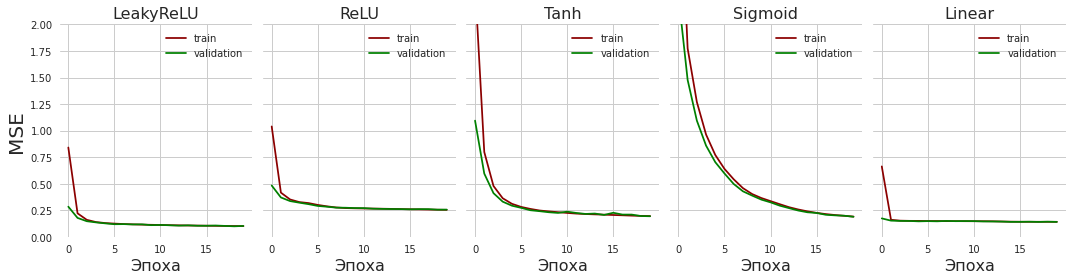

In [ ]:
import seaborn as sns
plt.style.use('seaborn')
sns.set_style("whitegrid")

activations = ['LeakyReLU', 'ReLU', 'Tanh', 'Sigmoid', 'Linear']

fig, ax = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
plt.ylim(0, 2)
for i, activation, autoencoder in zip(range(len(activations)), activations, autoencoders):
    print(autoencoder.history.history['loss'][-1])
    ax[i].plot(autoencoder.history.history['loss'][:20], label='train', c='darkred')
    ax[i].plot(autoencoder.history.history['val_loss'][:20], label='validation', c='green')
    ax[i].legend()
    ax[i].set_xlabel('Эпоха', size=16)
    ax[i].set_title(f'{activation}', size=16)
    if i == 0:
        ax[i].set_ylabel('MSE', size=20)
fig.tight_layout()
fig.savefig('drive/MyDrive/Coursework2021/simple_ae.png')

In [ ]:
text_embeddings = np.asarray(text_embeddings)
for autoencoder in autoencoders:
    embs = autoencoder(text_embeddings)
    print(mse(text_embeddings, embs))
    print(mape(text_embeddings, embs))
    print(r2_score(text_embeddings, embs))
    print()

0.080063954
0.5127028
0.9820984234071223

0.22001693
1.0042709
0.9510615992719517

0.1609012
0.7270919
0.964288337633161

0.105519585
0.74337566
0.9764239745638208

0.1256308
0.8272687
0.9717804160121999



In [ ]:
autoencoders[0].save('drive/MyDrive/Coursework2021/ae_simple_64.mdl')

INFO:tensorflow:Assets written to: drive/MyDrive/Coursework2021/ae_simple_64.mdl/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Coursework2021/ae_simple_64.mdl/assets


## Вторая архитектура

In [ ]:
from typing import Optional, Sequence, List
from keras.callbacks import History

class Autoencoder(Model):
    """
    Холдер для одного автоенкодера
    """
    def __init__(self, input_dim: int, output_dim: int, activation: Optional[str] = None) -> None:
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.build_autoencoder()

    def call(self, inputs):
        return self.autoencoder(inputs)

    def build_autoencoder(self) -> None:
        self.encoder = Sequential([
            InputLayer(input_shape=(self.input_dim,)),
            # Dense(90, activation='tanh'),
            # Dense(32, activation='relu'),
            Dense(self.output_dim, activation=self.activation)
        ])
        self.decoder = Sequential([
            InputLayer(input_shape=(self.output_dim,)),
            # Dense(32, activation='relu'),
            # Dense(90, activation='tanh'),
            Dense(self.input_dim, activation=None)
        ])
        self.autoencoder = Model(inputs=self.encoder.input, outputs=self.decoder(self.encoder.output))
        self.autoencoder.compile(loss='mse', optimizer='adam')


class StackedAutoencoder:
    """
    Ступенчатый автоенкодер: отдельно обучается каждый слой-encoder на основе результатов предыдущего слоя
    """
    def __init__(self, dims: Sequence[int], activation: Optional[str] = 'tanh') -> None:
        """:param dims: все размерности шагов (от input_dim до output_dim)"""
        self.dims = dims
        self.input_dim = dims[0]
        self.output_dim = dims[-1]
        self.autoencoders = [Autoencoder(dims[i - 1], dims[i], activation=activation) for i in range(1, len(dims))]

    def fit(self, train_data: np.ndarray, val_data: Optional[np.ndarray] = None, verbose: bool = False, epochs: int = 10) -> List[History]:
        if verbose:
            print(f'\nStackAutoencoder: fitting {len(self.autoencoders)} autoencoders with dimensions {self.dims}', flush=True)

        train_data_reduced = train_data
        val_data_reduced = val_data
        self.model_histories = []
        for i, autoencoder in enumerate(self.autoencoders):
            autoencoder.compile(loss='mse', optimizer='adam')
            if verbose:
                print(f'\tfitting autoencoder number {i} with dimensions {autoencoder.input_dim, autoencoder.output_dim}', file=sys.stderr)
            model_history = autoencoder.fit(
                x=train_data_reduced,
                y=train_data_reduced,
                epochs=epochs // 3,
                batch_size=32,
                validation_data=(val_data_reduced, val_data_reduced),
                validation_batch_size=32,
                shuffle=True,
                verbose=False,
                # callbacks=[tensorboard]
            )
            train_data_reduced = autoencoder.encoder(train_data_reduced)
            val_data_reduced = autoencoder.encoder(val_data_reduced)
            self.model_histories.append(model_history)
            if verbose:
                print(f'StackedAutoencoder: autoencoder {i} - model history\n{model_history.history}', flush=True)

        self.fine_tune(train_data, val_data, verbose, epochs)
        return self.model_histories

    def fine_tune(self, train_data: np.ndarray, val_data: Optional[np.ndarray] = None, verbose: bool = False, epochs: int = 10) -> None:
        """Дообучает всю цепь сразу"""
        if verbose:
            print(f'StackedAutoencoder: fine-tuning...')

        self.autoencoder_sequence = Sequential()
        for autoencoder in self.autoencoders:
            self.autoencoder_sequence.add(autoencoder.encoder)
        for autoencoder in self.autoencoders[::-1]:
            self.autoencoder_sequence.add(autoencoder.decoder)

        self.autoencoder_sequence.compile(loss='mse', optimizer='adam')
        self.finetune_history = self.autoencoder_sequence.fit(
            x=train_data,
            y=train_data,
            epochs=epochs,
            batch_size=32,
            validation_data=(val_data, val_data),
            validation_batch_size=32,
            shuffle=True,
            verbose=False
        )
        if verbose:
            print(f'StackedAutoencoder: fine-tuning history model history\n{self.finetune_history.history}')

    def encode(self, data: np.ndarray) -> np.ndarray:
        for autoencoder in self.autoencoders:
            data = autoencoder.encoder(data)
        return data

    def decode(self, data: np.ndarray) -> np.ndarray:
        for autoencoder in self.autoencoders[::-1]:
            data = autoencoder.decoder(data)
        return data

In [ ]:
sa = StackedAutoencoder([128, 90, 64], activation='LeakyReLU')

In [ ]:
import sys
sa.fit(train_sampled_embeds, val_sampled_embeds, verbose=True, epochs=50)


StackAutoencoder: fitting 2 autoencoders with dimensions [128, 90, 64]


	fitting autoencoder number 0 with dimensions (128, 90)


StackedAutoencoder: autoencoder 0 - model history
{'loss': [0.6377594470977783, 0.06030169129371643, 0.03953032195568085, 0.03488988056778908, 0.03354587405920029, 0.03284751996397972, 0.03256607800722122, 0.032345302402973175, 0.03239564225077629, 0.03210945799946785, 0.032061900943517685, 0.03198515251278877, 0.031910091638565063, 0.03175634518265724, 0.0316769964993, 0.03167802095413208], 'val_loss': [0.08819951117038727, 0.04522865638136864, 0.0370786227285862, 0.03412240743637085, 0.033562660217285156, 0.032205529510974884, 0.03376440703868866, 0.032371580600738525, 0.031387072056531906, 0.033127736300230026, 0.031649284064769745, 0.0314505472779274, 0.03134451434016228, 0.0337810292840004, 0.03141661733388901, 0.0318714939057827]}


	fitting autoencoder number 1 with dimensions (90, 64)


StackedAutoencoder: autoencoder 1 - model history
{'loss': [0.5222444534301758, 0.10364621132612228, 0.08927737921476364, 0.08672484755516052, 0.08574589341878891, 0.08508368581533432, 0.08478020876646042, 0.08453158289194107, 0.08441987633705139, 0.08421679586172104, 0.08407805860042572, 0.08394477516412735, 0.08380040526390076, 0.08370041847229004, 0.0835125669836998, 0.08342955261468887], 'val_loss': [0.1344284564256668, 0.08999878913164139, 0.08739802986383438, 0.08711052685976028, 0.08567249029874802, 0.08545758575201035, 0.08601657301187515, 0.08460182696580887, 0.08519443869590759, 0.08351269364356995, 0.08540146797895432, 0.0838824138045311, 0.08316695690155029, 0.0829300805926323, 0.08430264890193939, 0.08282577991485596]}
StackedAutoencoder: fine-tuning...
StackedAutoencoder: fine-tuning history model history
{'loss': [0.15553033351898193, 0.1483418345451355, 0.14606934785842896, 0.14342857897281647, 0.14234405755996704, 0.14169587194919586, 0.14141224324703217, 0.14102080464

In [ ]:
sa.finetune_history.history['loss']

[0.15553033351898193,
 0.1483418345451355,
 0.14606934785842896,
 0.14342857897281647,
 0.14234405755996704,
 0.14169587194919586,
 0.14141224324703217,
 0.14102080464363098,
 0.140832781791687,
 0.14061985909938812,
 0.1405462622642517,
 0.1405026763677597,
 0.14015135169029236,
 0.14040972292423248,
 0.1400858759880066,
 0.14020772278308868,
 0.13996484875679016,
 0.13992029428482056,
 0.13998229801654816,
 0.1397152841091156,
 0.13975904881954193,
 0.13975262641906738,
 0.13964296877384186,
 0.13964271545410156,
 0.13959971070289612,
 0.13943137228488922,
 0.13943269848823547,
 0.13947761058807373,
 0.13940328359603882,
 0.13933372497558594,
 0.13937914371490479,
 0.13928593695163727,
 0.13915883004665375,
 0.13935719430446625,
 0.1390049159526825,
 0.13916383683681488,
 0.13902780413627625,
 0.13903382420539856,
 0.13896521925926208,
 0.13891631364822388,
 0.13900695741176605,
 0.13898825645446777,
 0.13878966867923737,
 0.13898444175720215,
 0.13883677124977112,
 0.138896673917770

In [ ]:
text_embeddings = np.asarray(text_embeddings)
embs = sa.decode(sa.encode(text_embeddings))
    
print(mse(text_embeddings, embs))
print(mape(text_embeddings, embs))
print(r2_score(text_embeddings, embs))
print()

0.13016985
0.76163
0.9709440745297724



In [ ]:
autoencoders2 = []

for dims in [
    [128, 64],
    [128, 90, 64],
    [128, 90, 75, 64]
]:
    autoencoder = init_autoencoder(dims, 'LeakyReLU')
    autoencoder.fit(train_sampled_embeds, train_sampled_embeds, epochs=40, batch_size=32, verbose=True, shuffle=True)
    autoencoders2.append(autoencoder)

Epoch 1/40
3049/3049 [==============================] - 4s 1ms/step - loss: 2.2225
Epoch 2/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1794
Epoch 3/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1537
Epoch 4/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1497
Epoch 5/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1495
Epoch 6/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1485
Epoch 7/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1477
Epoch 8/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1469
Epoch 9/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1477
Epoch 10/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1470
Epoch 11/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1476
Epoch 12/40
3049/3049 [==============================] - 4s 1ms/step - loss: 0.1466
E

In [ ]:
text_embeddings = np.asarray(text_embeddings)
for autoencoder in autoencoders2:
    embs = autoencoder(text_embeddings)
    print(mse(text_embeddings, embs))
    print(mape(text_embeddings, embs))
    print(r2_score(text_embeddings, embs))
    print()

0.12836432
0.64156926
0.970939035363211

0.08077367
0.58321095
0.9817592012097383

0.07960732
0.4548959
0.9822737493016518



In [ ]:
sae2 = StackedAutoencoder([128, 90, 75, 64], activation='LeakyReLU')
sae2.fit(train_sampled_embeds, val_sampled_embeds, verbose=True, epochs=40)


StackAutoencoder: fitting 3 autoencoders with dimensions [128, 90, 75, 64]


	fitting autoencoder number 0 with dimensions (128, 90)


StackedAutoencoder: autoencoder 0 - model history
{'loss': [0.6345161199569702, 0.05888711288571358, 0.03921108320355415, 0.035018835216760635, 0.03371188044548035, 0.03296903148293495, 0.03263677656650543, 0.03234387934207916, 0.03214835003018379, 0.032280974090099335, 0.03195439651608467, 0.03190453723073006, 0.03169883415102959], 'val_loss': [0.08659002929925919, 0.043954841792583466, 0.03746893256902695, 0.03447553887963295, 0.03453933075070381, 0.03304985165596008, 0.031748656183481216, 0.031223798170685768, 0.03174027428030968, 0.031433913856744766, 0.03189661726355553, 0.030723579227924347, 0.03253541141748428]}


	fitting autoencoder number 1 with dimensions (90, 75)


StackedAutoencoder: autoencoder 1 - model history
{'loss': [0.5854238271713257, 0.059243593364953995, 0.04069654271006584, 0.037942271679639816, 0.03705883398652077, 0.03669488802552223, 0.036533862352371216, 0.036405354738235474, 0.03629959002137184, 0.03618583828210831, 0.03613787889480591, 0.03596608713269234, 0.03592526540160179], 'val_loss': [0.09584683179855347, 0.04379307106137276, 0.0381694994866848, 0.037655528634786606, 0.03710173815488815, 0.03654732182621956, 0.035749662667512894, 0.03506165370345116, 0.036199867725372314, 0.03505988419055939, 0.03575155884027481, 0.035841573029756546, 0.03604986146092415]}


	fitting autoencoder number 2 with dimensions (75, 64)


StackedAutoencoder: autoencoder 2 - model history
{'loss': [0.2947773337364197, 0.0348731093108654, 0.026956694200634956, 0.025863368064165115, 0.025505416095256805, 0.025303201749920845, 0.025202220305800438, 0.025076111778616905, 0.02490535005927086, 0.024710336700081825, 0.024504639208316803, 0.024270083755254745, 0.023955082520842552], 'val_loss': [0.05187302082777023, 0.028351226821541786, 0.02609407715499401, 0.026209335774183273, 0.025880662724375725, 0.025120289996266365, 0.024994991719722748, 0.02494095265865326, 0.024737879633903503, 0.024899620562791824, 0.02401641011238098, 0.023840351030230522, 0.0238190945237875]}
StackedAutoencoder: fine-tuning...
StackedAutoencoder: fine-tuning history model history
{'loss': [0.15962263941764832, 0.14714846014976501, 0.14626260101795197, 0.1454276591539383, 0.14483818411827087, 0.14474967122077942, 0.1440727710723877, 0.1439313143491745, 0.143743634223938, 0.1436990350484848, 0.14329084753990173, 0.1432003527879715, 0.14295664429664612,

In [ ]:
text_embeddings = np.asarray(text_embeddings)
embs = sae2.decode(sae2.encode(text_embeddings))
    
print(mse(text_embeddings, embs))
print(mape(text_embeddings, embs))
print(r2_score(text_embeddings, embs))
print()

0.13126431
0.8749095
0.970527982399806



In [ ]:
# baseline

from sklearn.decomposition import PCA

pca = PCA(64)
pca.fit(train_sampled_embeds)
embs = pca.transform(text_embeddings)
embs = pca.inverse_transform(embs)
    
print(mse(text_embeddings, embs))
print(mape(text_embeddings, embs))
print(r2_score(text_embeddings, embs))
print()

0.11956128
0.76768345
0.9730446271769997



In [ ]:
autoencoders2[-1].save('drive/MyDrive/Coursework2021/ae_bert_uncontext64.mdl')  

INFO:tensorflow:Assets written to: drive/MyDrive/Coursework2021/ae_bert_uncontext64.mdl/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Coursework2021/ae_bert_uncontext64.mdl/assets


In [ ]:
all_embeddings64 = autoencoders2[-1](all_embeddings)

In [ ]:
np.save('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab_embeddings64.npy', all_embeddings64.numpy())

In [ ]:
autoencoder32 = init_autoencoder(dims=[128, 80, 64, 48, 32], activation='LeakyReLU')
autoencoder32.fit(train_sampled_embeds, train_sampled_embeds, epochs=40, batch_size=32, verbose=True, shuffle=True)
np.save('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab_embeddings32.npy', all_embeddings32.numpy())

Epoch 1/40
3049/3049 [==============================] - 7s 2ms/step - loss: 2.4834
Epoch 2/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.9141
Epoch 3/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.7556
Epoch 4/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.6642
Epoch 5/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.6132
Epoch 6/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.5873
Epoch 7/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.5566
Epoch 8/40
3049/3049 [==============================] - 7s 2ms/step - loss: 0.5391
Epoch 9/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.5296
Epoch 10/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.5200
Epoch 11/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.5081
Epoch 12/40
3049/3049 [==============================] - 6s 2ms/step - loss: 0.4933
E

In [ ]:
autoencoder32 = autoencoder32(all_embeddings)
np.save('drive/MyDrive/Coursework2021/bert_uncased_L-12_H-128_A-2_vocab_embeddings32.npy', all_embeddings32.numpy())

# Контекстные

In [ ]:
train = np.load('drive/MyDrive/Coursework2021/autoencoder/embeddings_128.npy')

In [ ]:
train.shape

(801052, 128)

In [ ]:
aec = init_autoencoder([128, 64], 'LeakyReLU')
aec.fit(train[:100000, :], train[:100000, :], validation_split=0.1, batch_size=32, epochs=30, verbose=True)

Epoch 1/30
2813/2813 [==============================] - 4s 1ms/step - loss: 5.9626 - val_loss: 2.0097
Epoch 2/30
2813/2813 [==============================] - 4s 1ms/step - loss: 2.0395 - val_loss: 1.9675
Epoch 3/30
2813/2813 [==============================] - 4s 1ms/step - loss: 1.9978 - val_loss: 1.9438
Epoch 4/30
2813/2813 [==============================] - 4s 1ms/step - loss: 1.9904 - val_loss: 1.9446
Epoch 5/30
2813/2813 [==============================] - 4s 1ms/step - loss: 1.9853 - val_loss: 1.9257
Epoch 6/30
2813/2813 [==============================] - 4s 1ms/step - loss: 1.9787 - val_loss: 1.9299
Epoch 7/30
2813/2813 [==============================] - 4s 1ms/step - loss: 1.9683 - val_loss: 1.9241
Epoch 8/30
2813/2813 [==============================] - 4s 1ms/step - loss: 1.9640 - val_loss: 1.9199
Epoch 9/30
2813/2813 [==============================] - 4s 1ms/step - loss: 1.9653 - val_loss: 1.9245
Epoch 10/30
2813/2813 [==============================] - 4s 1ms/step - loss: 1.961

In [ ]:
aec2 = init_autoencoder([128, 90, 64], 'LeakyReLU')
aec2.fit(train[:100000, :], train[:100000, :], validation_split=0.1, batch_size=32, epochs=30, verbose=True)

Epoch 1/30
2813/2813 [==============================] - 177s 2ms/step - loss: 5.7013 - val_loss: 2.1400
Epoch 2/30
2813/2813 [==============================] - 5s 2ms/step - loss: 2.0996 - val_loss: 1.9880
Epoch 3/30
2813/2813 [==============================] - 5s 2ms/step - loss: 2.0143 - val_loss: 1.9469
Epoch 4/30
2813/2813 [==============================] - 5s 2ms/step - loss: 1.9858 - val_loss: 1.9362
Epoch 5/30
2813/2813 [==============================] - 5s 2ms/step - loss: 1.9699 - val_loss: 1.9352
Epoch 6/30
2813/2813 [==============================] - 5s 2ms/step - loss: 1.9599 - val_loss: 1.9168
Epoch 7/30
2813/2813 [==============================] - 5s 2ms/step - loss: 1.9580 - val_loss: 1.9168
Epoch 8/30
2813/2813 [==============================] - 5s 2ms/step - loss: 1.9519 - val_loss: 1.9262
Epoch 9/30
2813/2813 [==============================] - 5s 2ms/step - loss: 1.9424 - val_loss: 1.9146
Epoch 10/30
2813/2813 [==============================] - 5s 2ms/step - loss: 1.9

In [ ]:
aec3 = init_autoencoder([128, 105, 80, 64], 'LeakyReLU')
aec3.fit(train[:100000, :], train[:100000, :], validation_split=0.1, batch_size=32, epochs=30, verbose=True)

Epoch 1/30
2813/2813 [==============================] - 7s 2ms/step - loss: 6.1045 - val_loss: 2.7771
Epoch 2/30
2813/2813 [==============================] - 6s 2ms/step - loss: 2.7109 - val_loss: 2.3845
Epoch 3/30
2813/2813 [==============================] - 6s 2ms/step - loss: 2.3634 - val_loss: 2.1922
Epoch 4/30
2813/2813 [==============================] - 6s 2ms/step - loss: 2.2266 - val_loss: 2.0995
Epoch 5/30
2813/2813 [==============================] - 6s 2ms/step - loss: 2.1424 - val_loss: 2.0261
Epoch 6/30
2813/2813 [==============================] - 6s 2ms/step - loss: 2.0495 - val_loss: 2.0027
Epoch 7/30
2813/2813 [==============================] - 6s 2ms/step - loss: 2.0096 - val_loss: 1.9445
Epoch 8/30
2813/2813 [==============================] - 6s 2ms/step - loss: 1.9578 - val_loss: 1.8905
Epoch 9/30
2813/2813 [==============================] - 6s 2ms/step - loss: 1.9452 - val_loss: 1.8881
Epoch 10/30
2813/2813 [==============================] - 6s 2ms/step - loss: 1.925

In [ ]:
aecs = []
activations = ['LeakyReLU', 'ReLU', 'Tanh', 'Sigmoid', 'Linear']
for activ in activations:
    a = activ.lower() if activ != 'LeakyReLU' else activ
    aa = init_autoencoder([128, 64], a)
    aa.fit(train[:100000, :], train[:100000, :], verbose=True, validation_split=0.1, epochs=30, shuffle=True, batch_size=64)
    aecs.append(aa)

Epoch 1/30
1407/1407 [==============================] - 3s 2ms/step - loss: 7.7671 - val_loss: 2.1363
Epoch 2/30
1407/1407 [==============================] - 2s 2ms/step - loss: 2.1162 - val_loss: 1.9943
Epoch 3/30
1407/1407 [==============================] - 2s 1ms/step - loss: 2.0127 - val_loss: 1.9438
Epoch 4/30
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9877 - val_loss: 1.9700
Epoch 5/30
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9755 - val_loss: 1.9309
Epoch 6/30
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9715 - val_loss: 1.9502
Epoch 7/30
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9664 - val_loss: 1.9269
Epoch 8/30
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9625 - val_loss: 1.9272
Epoch 9/30
1407/1407 [==============================] - 2s 1ms/step - loss: 1.9637 - val_loss: 1.9237
Epoch 10/30
1407/1407 [==============================] - 2s 1ms/step - loss: 1.956

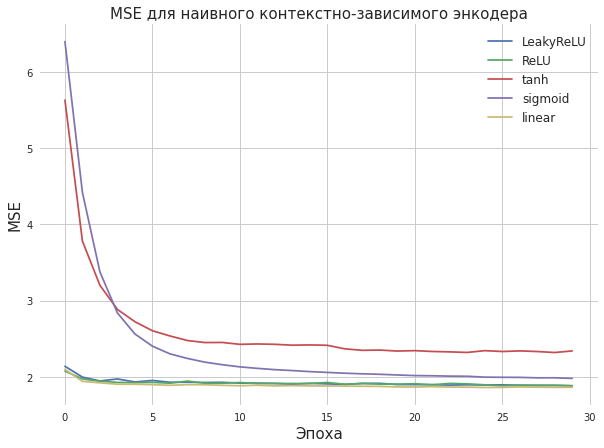

In [ ]:
f = plt.figure(figsize=(10, 7))
plt.plot(aecs[0].history.history['val_loss'], label='LeakyReLU')
plt.plot(aecs[1].history.history['val_loss'], label='ReLU')
plt.plot(aecs[2].history.history['val_loss'], label='tanh')
plt.plot(aecs[3].history.history['val_loss'], label='sigmoid')
plt.plot(aecs[4].history.history['val_loss'], label='linear')
plt.legend(fontsize='large')
plt.title('MSE для наивного контекстно-зависимого энкодера', size=15)
plt.xlabel('Эпоха', size=15)
plt.ylabel('MSE', size=15)
plt.show()
f.savefig('drive/MyDrive/Coursework2021/ae-bert-cont.png')

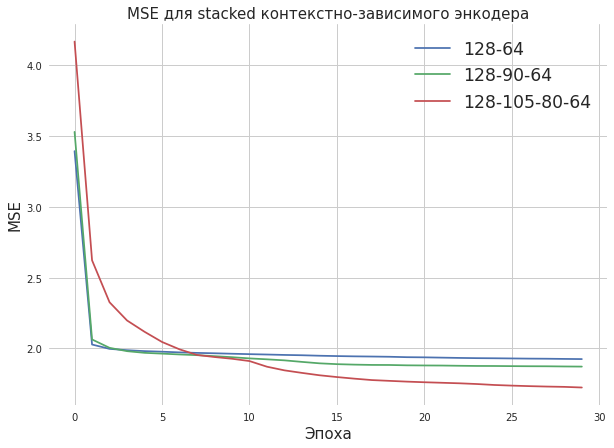

In [ ]:
f = plt.figure(figsize=(10, 7))
plt.plot(aec.history.history['loss'], label='128-64')
plt.plot(aec2.history.history['loss'], label='128-90-64')
plt.plot(aec3.history.history['loss'], label='128-105-80-64')
plt.legend(fontsize='xx-large')
plt.title('MSE для stacked контекстно-зависимого энкодера', size=15)
plt.xlabel('Эпоха', size=15)
plt.ylabel('MSE', size=15)
plt.show()
f.savefig('drive/MyDrive/Coursework2021/ae-bert-cont2.png')

# Ниже --- на оригининальных экспериментах (base_uncased, 768)

Должно быть 0.

In [ ]:
reduced_embeddings = encoder(all_embeddings)

def reduce_embedding(word, autoencoder=autoencoder):
    return encoder(get_embeddings(word)).numpy()[0]
    # return encoder(all_embeddings[all_tokens.index(word)].reshape(1, 768)).numpy()[0]

spatial.distance.cosine(reduce_embedding('king') - reduce_embedding('man') + reduce_embedding('woman'), reduce_embedding('queen'))

0.039967238903045654

In [ ]:
spatial.distance.cosine(reduce_embedding('king') - reduce_embedding('man') + reduce_embedding('raining'), reduce_embedding('queen'))

0.15001028776168823

Должно быть 1.

In [ ]:
reduced_embeddings.numpy().mean(axis=0)

array([-0.01662267,  0.9999345 , -0.55297816, -0.02291703,  0.16634402,
       -0.924784  , -0.11784021, -0.11145473,  0.17365946, -0.99895155,
       -1.        , -1.        ,  0.9348011 ,  0.6295178 , -0.01060687,
        0.19058064, -0.06295379,  0.09374467,  0.12911892,  0.9348011 ,
        0.7446825 ,  0.30369976, -0.12631159, -0.9999345 ,  0.08297139,
        0.79676825, -0.13369876, -0.09985589,  0.6179805 ,  0.3636957 ],
      dtype=float32)

Треть элементов в векторах даже не сдвинулись с нуля.

In [ ]:
# Checking property of king - man + woman = queen

property_check = {}

for word in ['king', 'queen', 'man', 'woman']:
    embs = get_embeddings(f'i can see a {word} over there')
    property_check[word] = embs[4]

_a = lambda x: property_check[x]

spatial.distance.cosine(_a('king') - _a('man') + _a('woman'), _a('queen'))

0.09832602739334106

# Проверяю воспроизводимость BERT

Верно ли вообще, что king - man + woman = queen?

In [ ]:
a = get_embeddings_from_last('king')
b = get_embeddings_from_last('queen')
np.mean((a - b) ** 2, axis=1)
spatial.distance.cosine(a[-1], b[-1])

0.13561415672302246

In [ ]:
embs = []
for word in ['boy', 'beauty', 'guy', 'woman']:
    embs.append(get_embeddings_from_last(f'the {word} passed a law'))

print('boy vs guy in same context:', cosine(embs[2][1], embs[0][1]))
print('boy vs beauty in same context:', cosine(embs[0][1], embs[1][1]))

boy vs guy in same context: 0.3710305690765381
boy vs beauty in same context: 0.3971129059791565


In [ ]:
embs = []

print('boy vs guy in no context:', cosine(get_embeddings_from_last('guy'), get_embeddings_from_last('boy')))
print('boy vs beauty in no context:', cosine(get_embeddings_from_last('beauty'), get_embeddings_from_last('boy')))

boy vs guy in no context: 0.19427704811096191
boy vs beauty in no context: 0.37730830907821655


In [ ]:
embs = []
for word in ['boy', 'beauty', 'guy', 'woman']:
    embs.append(get_embeddings_from_last(f'i ate the {word}'))

print('boy vs guy in same context:', cosine(embs[2][3], embs[0][3]))
print('boy vs beauty in same context:', cosine(embs[0][3], embs[1][3]))

boy vs guy in same context: 0.24570775032043457
boy vs beauty in same context: 0.3332405686378479


In [ ]:
def cosine(u, v):
    return spatial.distance.cosine(u, v), np.mean((u - v) ** 2) ** 0.5

embs = {}

for word in ['king', 'queen', 'man', 'woman']:
    embs[word] = []
    embs[word].append(get_embeddings(f'{word}'))
    embs[word].append(get_embeddings(f'{word} is the best'))
    embs[word].append(get_embeddings(f'we know the {word}'))
    embs[word].append(get_embeddings(f'{word} {word}'))

print('VARIOUS DISTANCES BETWEEN KING AND QUEEN:')
print(cosine(embs['king'][0][0], embs['queen'][0][0]))
print(cosine(embs['king'][1][0], embs['queen'][1][0]))
print(cosine(embs['king'][2][-1], embs['queen'][2][-1]))
print(cosine(embs['king'][3][0], embs['queen'][3][0]))
print()

print('VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (SAME CONTEXT):')
print(cosine(embs['king'][0][0] - embs['man'][0][0] + embs['woman'][0][0], embs['queen'][0][0]))
print(cosine(embs['king'][1][0] - embs['man'][1][0] + embs['woman'][1][0], embs['queen'][1][0]))
print(cosine(embs['king'][2][-1] - embs['man'][2][-1] + embs['woman'][2][-1], embs['queen'][2][-1]))
print(cosine(embs['king'][3][0] - embs['man'][3][0] + embs['woman'][3][0], embs['queen'][3][0]))
print()

print('VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (DIFFERENT CONTEXT):')
print(cosine(embs['king'][0][0] - embs['man'][1][0] + embs['woman'][2][-1], embs['queen'][3][0]))
# print(cosine(embs['king'][1][0] - embs['man'][1][0] + embs['woman'][1][0], embs['queen'][1][0]))
# print(cosine(embs['king'][2][-1] - embs['man'][2][-1] + embs['woman'][2][-1], embs['queen'][2][-1]))
# print(cosine(embs['king'][3][0] - embs['man'][3][0] + embs['woman'][3][0], embs['queen'][3][0]))
print()

print('NON-ZERO DISTANCES BETWEEN SAME WORDS (DEPEND ON CONTEXT)')
for word in ['king', 'queen', 'man', 'woman']:
    print(cosine(embs[word][0][0], embs[word][1][0]))
    print(cosine(embs[word][1][0], embs[word][2][-1]))
    print(cosine(embs[word][2][-1], embs[word][3][0]))
    print(cosine(embs[word][3][0], embs[word][3][1]))
    print(cosine(embs[word][3][0], embs[word][0][0]))
    print()

VARIOUS DISTANCES BETWEEN KING AND QUEEN:
(0.11764466762542725, 1.105831019483693)
(0.16463828086853027, 1.3402670589187504)
(0.11030858755111694, 1.0856982180205963)
(0.1686956286430359, 1.4168673354498114)

VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (SAME CONTEXT):
(0.2166770100593567, 1.5660456292238996)
(0.16117733716964722, 1.348344091051062)
(0.11721783876419067, 1.1732443882994747)
(0.2791459560394287, 2.060554627318059)

VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (DIFFERENT CONTEXT):
(0.6227806210517883, 3.3543426435916883)

NON-ZERO DISTANCES BETWEEN SAME WORDS (DEPEND ON CONTEXT)
(0.4145054221153259, 2.08452658495257)
(0.37392497062683105, 1.9949899745870912)
(0.34623342752456665, 1.9753107019677871)
(0.2657058835029602, 1.7919402985505226)
(0.26635509729385376, 1.7236887633668536)

(0.4855496883392334, 2.291434455435265)
(0.44787508249282837, 2.213693579154562)
(0.4431809186935425, 2.2443184645183987)
(0.3137674331665039, 1.9529077027559183)
(0.31835770606994

In [ ]:
print('WORD GREEN IN DIFFERENT CONTEXTS')
print(cosine(get_embeddings_from_last('green sofa')[0], get_embeddings_from_last('green chair')[0]))
print(cosine(get_embeddings_from_last('green sofa')[0], get_embeddings_from_last('green box')[0]))
print(cosine(get_embeddings_from_last('green box')[0], get_embeddings_from_last('light green')[1]))

WORD GREEN IN DIFFERENT CONTEXTS
0.12123119831085205
0.44215917587280273
0.6706148087978363


In [ ]:
print('WORD GREEN IN DIFFERENT CONTEXTS (sum of four hidden)')
print(cosine(get_embeddings('green sofa')[0], get_embeddings('green chair')[0]))
print(cosine(get_embeddings('green sofa')[0], get_embeddings('green box')[0]))
print(cosine(get_embeddings('green box')[0], get_embeddings('light green')[1]))

WORD GREEN IN DIFFERENT CONTEXTS (sum of four hidden)
0.098857581615448
0.3535335659980774
0.48835980892181396


In [ ]:
def cosine(u, v):
    return spatial.distance.cosine(u, v), np.mean((u - v) ** 2) ** 0.5

embs = {}

for word in ['king', 'queen', 'man', 'woman']:
    embs[word] = []
    embs[word].append(encoder(get_embeddings(f'{word}')).numpy()[0])
    embs[word].append(encoder(get_embeddings(f'{word} is the best')).numpy()[0])
    embs[word].append(encoder(get_embeddings(f'we know the {word}')).numpy()[-1])
    embs[word].append(encoder(get_embeddings(f'{word} {word}')).numpy()[0])

print('VARIOUS DISTANCES BETWEEN KING AND QUEEN:')
print(cosine(embs['king'][0], embs['queen'][0]))
print(cosine(embs['king'][1], embs['queen'][1]))
print(cosine(embs['king'][2], embs['queen'][2]))
print(cosine(embs['king'][3], embs['queen'][3]))
print()

print('VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (SAME CONTEXT):')
print(cosine(embs['king'][0] - embs['man'][0] + embs['woman'][0], embs['queen'][0]))
print(cosine(embs['king'][1] - embs['man'][1] + embs['woman'][1], embs['queen'][1]))
print(cosine(embs['king'][2] - embs['man'][2] + embs['woman'][2], embs['queen'][2]))
print(cosine(embs['king'][3] - embs['man'][3] + embs['woman'][3], embs['queen'][3]))
print()

print('VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (DIFFERENT CONTEXT):')
print(cosine(embs['king'][0] - embs['man'][1] + embs['woman'][2], embs['queen'][3]))
# print(cosine(embs['king'][1][0] - embs['man'][1][0] + embs['woman'][1][0], embs['queen'][1][0]))
# print(cosine(embs['king'][2][-1] - embs['man'][2][-1] + embs['woman'][2][-1], embs['queen'][2][-1]))
# print(cosine(embs['king'][3][0] - embs['man'][3][0] + embs['woman'][3][0], embs['queen'][3][0]))
print()

print('NON-ZERO DISTANCES BETWEEN SAME WORDS (DEPEND ON CONTEXT)')
for word in ['king', 'queen', 'man', 'woman']:
    print(cosine(embs[word][0], embs[word][1]))
    print(cosine(embs[word][1], embs[word][2]))
    print(cosine(embs[word][2], embs[word][3]))
    print(cosine(embs[word][3], embs[word][3]))
    print(cosine(embs[word][3], embs[word][0]))
    print()

VARIOUS DISTANCES BETWEEN KING AND QUEEN:
(0.03471952676773071, 0.5911668249988083)
(0.03196495771408081, 0.44152428728265025)
(0.01817035675048828, 0.36047307475273216)
(0.018519699573516846, 0.4409981250247325)

VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (SAME CONTEXT):
(0.10986948013305664, 1.0321878734545216)
(0.037877440452575684, 0.4812532548670496)
(0.028219759464263916, 0.4522282672054851)
(0.11279302835464478, 1.1085525472778879)

VARIOUS DISTANCES BETWEEN KING-QUEEN+MAN AND WOMAN (DIFFERENT CONTEXT):
(0.40068870782852173, 2.1788129248316785)

NON-ZERO DISTANCES BETWEEN SAME WORDS (DEPEND ON CONTEXT)
(0.24522197246551514, 1.3906634893341439)
(0.13141494989395142, 0.9260694481737757)
(0.13576346635818481, 1.0890955937746951)
(0.0, 0.0)
(0.17969214916229248, 1.2836428836606082)

(0.27415257692337036, 1.5540259405791526)
(0.19970154762268066, 1.1639237289150726)
(0.22871029376983643, 1.4550715708745008)
(0.0, 0.0)
(0.2279752492904663, 1.5284181216206156)

(0.3310208320617

Выводы: значительно зависит от контекста. `king - man + woman = queen` в целом проходит проверку, но не очень хорошо и в разных ситуациях по-разному. Есть проблемы с пониманием, что же такое векторное представление BERT и надо ли его пихать в эту задачу.

In [ ]:
# Далее: 
# 1. Доделать автоенкодер (дообучить, изменить).
# 2. Посмотреть равенства и для PCA, и для автоенкодера.
# 3. Пробежать метриками по уменьшенным эмбеддингам.
# 4. Обучить w2v.

Ещё раз PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(30)
reduced_embeddings_pca = pca.fit_transform(all_embeddings)
reduced_embeddings_pca.shape

(30522, 30)

In [ ]:
cosine(pca.transform(get_embeddings('king')) - pca.transform(get_embeddings('man')) + pca.transform(get_embeddings('woman')),
       pca.transform(get_embeddings('queen')))

(0.5047992467880249, 4.7646149112048075)